In [1]:
import pandas as pd
import numpy as np
import operator
import pickle
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from matplotlib import pyplot as plt
from nn_utils import MatrixFactorization
from itertools import zip_longest,combinations
import math
from datetime import datetime
from collections import defaultdict
import copy
import scipy.sparse as sp
from recommendation_utils import get_ib_recommendations, get_pop_recommendations,get_mf_recommendations,get_ub_recommendations, get_nn_recommendations, get_random_recommendations,get_simrank_recommendations
import gc
import pycmf

/Users/steheri/opt/anaconda3/envs/compnet/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


We define the experiment parameters

In [2]:
dataset = 'mimic'  #valid options are decagon,medical,movielens,mimic
seed = 0 # By changing this value, we get differenet random splits for train, test sets
train_test_split = 0.8 # This value shows the % of the train and data set
min_items = 15
top_n = 5 # This is used for creating precision - recall charts, 10 for mimic
neighborhood = 80 # The neighborhood to use for using UBCF
similarity_coefficient = 0.8
train_batch =512 # Used for training the NN
methods = ['Pathsim','IBCF','MF']
ddi_datasets = ['mimic']

We load the dataset 

In [3]:
df = pd.read_csv('mimic.csv')
columns = ['patient','drug']
df = df[columns]
columns = ['user','drug']
df_ddi = pd.read_csv('mimic_ddi.csv')
df_ddi = df_ddi[['Drug1','Drug2']]    
df.columns = columns
df.head()


,user,drug
0,0,C07A
1,0,A07A
2,0,M01A
3,0,A06A
4,0,N02B


In [4]:

temp_df = df.groupby('user')['drug'].unique()
medicines=[]
counter =0
counter_temp= []
for i in range(0, len(temp_df)):
    if len(temp_df.iloc[i]) > 15:
        counter_temp.append(counter)
        user_medicine = f"{temp_df.iloc[i][0]}"
        for drug in range(1, len(temp_df.iloc[i])):
            user_medicine += f' {temp_df.iloc[i][drug]}'
        medicines.append(user_medicine)
    counter+=1
all_users = list(df['user'].unique())
users_to_keep = []
for user in all_users:
    if len(temp_df.loc[user])>min_items:
        users_to_keep.append(user)
train_df = df[df.user.isin(users_to_keep)]
train_df =  train_df.drop_duplicates()
train_df = train_df.sort_values(by='user')
train_df = train_df.reset_index()
train_df = train_df.drop('index',axis=1)
# records=dill.load(open('records_final_for_my.pkl','rb'))
# data_to_keep =[records[x] for x in users_to_keep]
# len(data_to_keep)
# #     del records
# diagnosis = [row[0] for row in data_to_keep]
# procedures = [row[1] for row in data_to_keep]
# medicines = [row[2] for row in data_to_keep]
# medicines_temp =[]
# diagnosis_temp = []
# procedure_temp = []
# diagnosis_df = []

# for row in range(0,len(medicines),1):
#     medicine = medicines[row]
#     if len(medicine.split(" "))>15:
#         medicines_temp.append(medicine)
# 
#         diagnosis_temp.append(diagnosis[row])
#         user_diagnosis = diagnosis[row].split(" ")
#         for diagnosi in user_diagnosis:
#             diagnosis_df.append((row,diagnosi))
#         procedure_temp.append(procedures[row])
#     counter+=1
# diagnosis_df = pd.DataFrame(diagnosis_df)
# diagnosis_df.columns= ['user','diagnosis']
# medicines = medicines_temp
# diagnosis= diagnosis_temp
# procedures = procedure_temp
# #     medicines_temp = []
# #     for medicine in medicines:
# #         if len(medicine.split(" "))>15:
# #             medicines_temp.append(medicine)
# #     medicines = medicines_temp
# medicines_tokenizer = Tokenizer()
# medicines_tokenizer.fit_on_texts(medicines)
# medicines_maxlen = max([len(line.split(' ')) for line in medicines])
# sequences = medicines_tokenizer.texts_to_sequences(medicines)

# padded_medicines = pad_sequences(sequences, maxlen=medicines_maxlen, padding='post', truncating='post')
# diagnosis_maxlen=max([len(line.split(' ')) for line in diagnosis])
# procedure_maxlen=max([len(line.split(' ')) for line in procedures])
# medicines_maxlen = max([len(line.split(' ')) for line in medicines])
# # Creating a bag-of-words for Diagnosis and Procedures sets
# # Each diagnosis/procedure code is taken from the EHR input file
# diagnosis_tokenizer = Tokenizer()
# diagnosis_tokenizer.fit_on_texts(diagnosis)
# sequences = diagnosis_tokenizer.texts_to_sequences(diagnosis)

# diagnosis_= pad_sequences(sequences, maxlen=diagnosis_maxlen, padding='post', truncating='post')

# procedure_tokenizer=Tokenizer()
# procedure_tokenizer.fit_on_texts(procedures)
# sequences=procedure_tokenizer.texts_to_sequences(procedures)

# procedure_=pad_sequences(sequences,maxlen=procedure_maxlen,padding='post',truncating='post')
# diseases_to_train = []
# medicines_to_train = []
# for x,z, y in zip(diagnosis_, procedure_,padded_medicines):
#     diseases_to_train.append([x,z])
#     medicines_to_train.append([y])
# diagnosis_icd =pd.read_csv('D_ICD_DIAGNOSES.csv')
# diagnosis_icd= diagnosis_icd[['ICD9_CODE','SHORT_TITLE']]
# procedures_icd =pd.read_csv('D_ICD_PROCEDURES.csv')
# procedures_icd= procedures_icd[['ICD9_CODE','SHORT_TITLE']]
atc_drug= pickle.load(open( "atc_drug.pkl", "rb" ))

print(f'Users : {len(train_df.user.unique())}, Drugs : {len(train_df.drug.unique())}')
print(train_df.shape)
patient_ids= list(train_df['user'].unique())
train_df.head()


Users : 1701, Drugs : 122
(31235, 2)


,user,drug
0,2,C07A
1,2,C10A
2,2,A01A
3,2,N06A
4,2,A03B


We can view the correspondance between the drugs we have (codes from the dataset) and how we encode them in columns

In [5]:
data_list = train_df.values.tolist()
overlapping_drugs = []
current_patient = data_list[0][0]
current_drugs =[]
for p_d in data_list:
    if p_d[0] == current_patient:
        current_drugs.append(p_d[1])
    else:
        overlapping_drugs.append(current_drugs)
        current_drugs = []
        current_drugs.append(p_d[1])
        current_patient = p_d[0]
drugs = []
dict_drug = {}
count= 0
for drug_list in overlapping_drugs:
    for drug in drug_list:
        if drug not in dict_drug.keys():
            dict_drug[drug] = count
            drugs.append(count)
            count+=1
drugs = np.asarray(drugs)
dict_drug['END'] = count
medicineSet=[]
new_medicines = []
for row in medicines:
    medicine_row = []
    for item in row.split(' '):
        medicine_row.append(item)
        if item not in medicineSet:
            medicineSet.append(item)
    new_medicines.append(medicine_row)
if dataset=='medical_2':
    medicineSet1=[]
    new_test_medicines = []
    for row in test_medicines:
        medicine_row = []
        for item in row.split(' '):
            medicine_row.append(item)
            if item not in medicineSet:
                medicineSet.append(item)
        new_test_medicines.append(medicine_row)
drug2id={drug:id for id,drug in enumerate(medicineSet)}
drug2id['END']=len(drug2id)
drug2id

{'C07A': 0,
 'A06A': 1,
 'A02A': 2,
 'J01M': 3,
 'C02A': 4,
 'B05C': 5,
 'B01A': 6,
 'C03C': 7,
 'A12A': 8,
 'A11C': 9,
 'A12B': 10,
 'C03A': 11,
 'A03B': 12,
 'N06A': 13,
 'A01A': 14,
 'C10A': 15,
 'A07A': 16,
 'N02B': 17,
 'A12C': 18,
 'H03A': 19,
 'J01D': 20,
 'B02B': 21,
 'A02B': 22,
 'A10A': 23,
 'C01C': 24,
 'R06A': 25,
 'C01B': 26,
 'M01A': 27,
 'N07A': 28,
 'N01A': 29,
 'C01D': 30,
 'A03F': 31,
 'N02A': 32,
 'N05B': 33,
 'D04A': 34,
 'D07A': 35,
 'C01E': 36,
 'J05A': 37,
 'J01E': 38,
 'N05C': 39,
 'R05C': 40,
 'C05A': 41,
 'J01F': 42,
 'R01A': 43,
 'R05D': 44,
 'R03A': 45,
 'A04A': 46,
 'N04B': 47,
 'G04C': 48,
 'V03A': 49,
 'A07E': 50,
 'C08C': 51,
 'C09X': 52,
 'C02D': 53,
 'N03A': 54,
 'C09A': 55,
 'B03A': 56,
 'M03A': 57,
 'B02A': 58,
 'D01A': 59,
 'J01C': 60,
 'R03D': 61,
 'H03B': 62,
 'B03B': 63,
 'N06B': 64,
 'S01E': 65,
 'N05A': 66,
 'H05B': 67,
 'J01X': 68,
 'D06A': 69,
 'G03C': 70,
 'A11D': 71,
 'D08A': 72,
 'N07B': 73,
 'L04A': 74,
 'C09C': 75,
 'A10B': 76,
 'G04B': 

We iterate each user and create an array with each one corresponding index to interests

In [6]:
patient_drug_list = []
if dataset =='medical_2':
    patient_test_drug_list=[]
    for patient_drugs in new_test_medicines:

        drugs_per_patient = []
        for drug in patient_drugs: 
            drugs_per_patient.append(drug2id[drug])

        patient_test_drug_list.append(drugs_per_patient)

for patient_drugs in new_medicines:

    drugs_per_patient = []
    for drug in patient_drugs: 
        drugs_per_patient.append(drug2id[drug])

    patient_drug_list.append(drugs_per_patient)
patient_drug_list

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 1, 6, 13, 14, 18, 19, 20, 21, 22, 15, 23, 24, 5, 25, 26],
 [16, 27, 17, 14, 22, 1, 8, 18, 5, 28, 23, 24, 29, 30, 31, 32],
 [16, 18, 10, 1, 25, 7, 33, 34, 14, 35, 36, 37, 38, 39, 40, 41],
 [0, 16, 17, 18, 19, 1, 42, 43, 44, 45, 20, 33, 46, 47, 15, 48],
 [1, 6, 22, 34, 49, 0, 32, 50, 51, 4, 52, 13, 53, 54, 29, 26],
 [1, 17, 2, 8, 18, 22, 46, 32, 0, 6, 52, 53, 51, 30, 3, 50],
 [1, 17, 6, 22, 49, 0, 32, 50, 51, 4, 52, 13, 53, 54, 26, 33],
 [17, 1, 18, 6, 14, 15, 22, 29, 39, 43, 41, 45, 5, 35, 0, 42, 55, 20],
 [17, 14, 22, 1, 8, 6, 18, 15, 5, 23, 24, 29, 36, 45, 26, 32, 0, 56, 3],
 [0, 17, 22, 1, 8, 6, 14, 18, 5, 53, 28, 23, 24, 29, 10, 32, 27],
 [0, 17, 8, 5, 6, 18, 1, 53, 23, 24, 29, 39, 57, 22, 14, 33, 32, 34, 58, 59],
 [17, 22, 1, 8, 10, 5, 18, 53, 28, 14, 23, 24, 29, 32, 35, 27],
 [0, 16, 17, 18, 8, 6, 14, 22, 24, 5, 26, 7, 19, 15, 32, 43, 45, 42, 20, 50],
 [0, 18, 8, 5, 6, 14, 24, 53, 1, 23, 29, 30, 22, 3, 20, 15],
 [0

In [7]:
# medicines = []
# for i in range(0,len(patient_drug_list)):
#     user_medicine = f'{patient_drug_list[i][0]}'
#     for drug in range(1,len(patient_drug_list[i])):
#         user_medicine+= f' {patient_drug_list[i][drug]}'
#     medicines.append(user_medicine)
# medicines_maxlen = max([len(line.split(' ')) for line in medicines])
# medicines_tokenizer = Tokenizer()
# medicines_tokenizer.fit_on_texts(medicines)


We define the train split and split into train and test

In [8]:
np.random.seed(seed)
train_set=[]
test_set =[]
count = 0
train_medicines = []

for user_interests in patient_drug_list:
    user_interests = np.asarray(user_interests)

    indices = np.arange(len(user_interests))

    np.random.shuffle(indices)

    train_end = int(train_test_split*len(user_interests))
    train_indices = indices[:train_end]

    train_indices = user_interests[train_indices]

    test_indices = indices[train_end:]
    test_indices = user_interests[test_indices]
    train_interests = np.zeros(len(drugs))
    test_interests = np.zeros(len(drugs))
    print(train_indices)
    train_interests[train_indices] = 1
    train_medicines.append(train_indices)
    train_set.append(train_interests)
    test_interests[test_indices] = 1
    test_set.append(test_interests)
    print(f'Patient {count} has taken {len(user_interests)} drugs, {len(train_indices)} drugs are in the train set, {len(test_indices)} drugs are in his test set')
    count+=1
cancer_data = 0
# rl_data_x, rl_data_y, drug2id = load_records( cancer_data =cancer_data,min_items= min_items, train_test_split = train_test_split,dataset = dataset)



[ 1  6  8  9 13  4  2 14 10  7 15 11]
Patient 0 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[ 1 25 24 22 16  6 13 15 23 21 14 26 20]
Patient 1 has taken 17 drugs, 13 drugs are in the train set, 4 drugs are in his test set
[ 1 30 18 22 23 31  8 24 28 29 27  5]
Patient 2 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[37 14 18  7 33 39 35 41 40 38 10  1]
Patient 3 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[ 0 42 48 17  1 18 33 15 43 46 16 44]
Patient 4 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[ 6 22 53 26 54 50 51 32 13 49 52  4]
Patient 5 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[ 2 30 53 51 46 50 17  1  6 22 32 52]
Patient 6 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[52 32 51 53 50  4 22 33 54 13 49  6]
Patient 7 has taken 16 drugs, 12 drugs are in the train set, 4 drugs a

[23  1 54 22  4  6 51 31 30 66 49 55 46]
Patient 718 has taken 17 drugs, 13 drugs are in the train set, 4 drugs are in his test set
[  2  53  13   5  17 109  23   1  49   6  32  78  46  26  31  14]
Patient 719 has taken 20 drugs, 16 drugs are in the train set, 4 drugs are in his test set
[ 1 31 51 23  0 22 46 13  4 32 34 54]
Patient 720 has taken 16 drugs, 12 drugs are in the train set, 4 drugs are in his test set
[29  3 16 42 20 18 50 63 32  5 24  6 35 87  0]
Patient 721 has taken 19 drugs, 15 drugs are in the train set, 4 drugs are in his test set
[ 66  32   0   8  20  22  14   5   6  21 104  16  18]
Patient 722 has taken 17 drugs, 13 drugs are in the train set, 4 drugs are in his test set
[33 18 43 31 60 13 55 45 16 41  1  5  2]
Patient 723 has taken 17 drugs, 13 drugs are in the train set, 4 drugs are in his test set
[ 2 39  1 20 35 34 42  6 45 13 43 14 16 22 18]
Patient 724 has taken 19 drugs, 15 drugs are in the train set, 4 drugs are in his test set
[14 18 60 22 49 66 55  6 20 9

[ 5 29 50 26 37 51  1 24 16  0 22 46 95 82  8  3 32 10 74]
Patient 1218 has taken 24 drugs, 19 drugs are in the train set, 5 drugs are in his test set
[ 8 17  1 33  2 18 22 32 30  5 15 24 16 14 23 78]
Patient 1219 has taken 20 drugs, 16 drugs are in the train set, 4 drugs are in his test set
[29 22  1 20 24 31 28 32  5 30 18 23 14]
Patient 1220 has taken 17 drugs, 13 drugs are in the train set, 4 drugs are in his test set
[ 8  1 15 20 14 18 16 29 31 24 28  5 30 69 53 45]
Patient 1221 has taken 20 drugs, 16 drugs are in the train set, 4 drugs are in his test set
[23  1 24 31 22  8 18 29 17 20 32 28 57 14 61 15]
Patient 1222 has taken 20 drugs, 16 drugs are in the train set, 4 drugs are in his test set
[ 0 45  1 57 22 23  3  6 16  5 32 18 14  2 17 40]
Patient 1223 has taken 20 drugs, 16 drugs are in the train set, 4 drugs are in his test set
[  1  23 104   5  17  28  10  26  18  15  30   0  32   2  24  22]
Patient 1224 has taken 21 drugs, 16 drugs are in the train set, 5 drugs are in his

We calcuate the user similarities and item similarities

In [9]:
# if dataset =='mimic':
#     diagnosis_dict = {}# We create a dict in order to have each diagnosis as an int
#     count = 0
#     for i in list(diagnosis_df['diagnosis'].unique()):

#         diagnosis_dict[i] = count
#         count+=1
    
#     diagnosis_train_set = np.zeros(shape = [len(diagnosis_df['user'].unique()),len(diagnosis_df['diagnosis'].unique())])
#     #diagnosis_train_set is an array with rows as patients and columns as diseases
#     diagnosis_list = diagnosis_df.values.tolist()
#     for i in diagnosis_list:
#         diagnosis_train_set[i[0]][diagnosis_dict[i[1]]] = 1#We set ones to the diseases of each patient
#     diagnosis_train_set

In [10]:
net = MatrixFactorization(
    np.asarray(train_set).shape[0], np.asarray(train_set).shape[1], 
    n_factors=5)

def user_user_cosine_similarity(train_set):
    A_sparse = sparse.csr_matrix(train_set)
    user_similarities = cosine_similarity(A_sparse)    
    return user_similarities


def drug_drug_cosine_similarity(train_set):
    A_sparse = sparse.csr_matrix(train_set)
    drug_similarities = cosine_similarity(A_sparse.T)    
    return drug_similarities

def mf_similarity(train_set):
    from scipy.sparse.linalg import svds
    A_sparse = sparse.csr_matrix(train_set)
    U, sigma, Vt = svds(A_sparse, k = 50)
    #drug_similarities = cosine_similarity(Vt.T)
    sigma = np.diag(sigma)
    user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    return user_predicted_ratings
def mf_similarity_2(train_set,ddi=False,ddi_net = None):
    from scipy.sparse.linalg import svds
    if ddi:
        model = pycmf.CMF(n_components=50)
        U,V,Z =model.fit_transform(np.asarray(train_set),ddi_net)
        drug_similarities = cosine_similarity(V)
    else:
        A_sparse = sparse.csr_matrix(train_set)

        U, sigma, Vt = svds(A_sparse, k = 50)
        drug_similarities = cosine_similarity(Vt.T)
#     sigma = np.diag(sigma)
#     user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    return drug_similarities

def pathsim_drug_drug_similarity(train_set,ddi=0,ddi_net = None):
    train_data = np.asarray(train_set)
    patients= []
    for i in range(0,train_data.shape[0]):
        patients.append(f'P{i}')
    drugs = []
    for i in range(0,train_data.shape[1]):
        drugs.append(f'D{i}')

    g = nx.Graph()
    g.add_nodes_from(patients, entity='P')
    g.add_nodes_from(drugs, entity='D')
    edges = np.where(train_data==1)
    for i in range(0,len(edges[0])):
        patient = 'P'+str(edges[0][i])
        drug = 'D'+str(edges[1][i])
        g.add_edge(patient,drug, edge_type='PD') 
    if ddi:
        for ddi_pair in ddi_net:
            d1 = 'D'+str(ddi_pair[0])
            d2 = 'D'+str(ddi_pair[1])
            g.add_edge(d1,d2,edge_type = 'DD')
    path_len = 1
    target_entity = 'D'
    adj_entity = 'P'
    G= g
    target_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == target_entity]
    adj_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == adj_entity]

    # ------ Calculating Adjacency matrix between target and adjacency nodes
    adj = defaultdict(list)

    for n1 in target_nodes:
        adj[n1] = defaultdict(list)
        for n2 in adj_nodes:
            adj[n1][n2] = len([path for path in nx.all_simple_paths(G, n1, n2, path_len)])

    # ------ Calculating similarities between target nodes
    sim = defaultdict(list)
    n_paths = defaultdict(list)

    for n1 in target_nodes:
        sim[n1] = defaultdict(int) #list
        n_paths[n1] = defaultdict(int)
        for n2 in target_nodes:
            sim[n1][n2] = -1
            n_paths[n1][n2] = 0

    for n1 in target_nodes:
        for n2 in target_nodes:
            if sim[n2][n1] == -1:
                n_connecting_paths = 0
                numerator = 0
                denominator = 0
                for n3 in adj_nodes:
                    n_connecting_paths += adj[n1][n3] * adj[n2][n3]
                    numerator += 2 * adj[n1][n3] * adj[n2][n3]
                    denominator += adj[n1][n3] ** 2 + adj[n2][n3] ** 2
                sim[n1][n2] = numerator / denominator if denominator != 0 else 0
                sim[n2][n1] = sim[n1][n2]
                n_paths[n1][n2] = n_connecting_paths
                n_paths[n2][n1] = n_paths[n1][n2]
    df = pd.DataFrame(data =sim)
    if ddi:
        target_entity = 'D'
        adj_entity = 'D'
        G= g
        target_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == target_entity]
        adj_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == adj_entity]

        # ------ Calculating Adjacency matrix between target and adjacency nodes
        adj = defaultdict(list)

        for n1 in target_nodes:
            adj[n1] = defaultdict(list)
            for n2 in adj_nodes:
                adj[n1][n2] = len([path for path in nx.all_simple_paths(G, n1, n2, path_len)])

        # ------ Calculating similarities between target nodes
        sim_ddi = defaultdict(list)
        n_paths = defaultdict(list)

        for n1 in target_nodes:
            sim_ddi[n1] = defaultdict(int) #list
            n_paths[n1] = defaultdict(int)
            for n2 in target_nodes:
                sim_ddi[n1][n2] = -1
                n_paths[n1][n2] = 0

        for n1 in target_nodes:
            for n2 in target_nodes:
                if sim_ddi[n2][n1] == -1:
                    n_connecting_paths = 0
                    numerator = 0
                    denominator = 0
                    for n3 in adj_nodes:
                        n_connecting_paths += adj[n1][n3] * adj[n2][n3]
                        numerator += 2 * adj[n1][n3] * adj[n2][n3]
                        denominator += adj[n1][n3] ** 2 + adj[n2][n3] ** 2
                    sim_ddi[n1][n2] = numerator / denominator if denominator != 0 else 0
                    sim_ddi[n2][n1] = sim_ddi[n1][n2]
                    n_paths[n1][n2] = n_connecting_paths
                    n_paths[n2][n1] = n_paths[n1][n2]
        df_ddi = pd.DataFrame(data = sim_ddi)
        
        
        df = df.add(-1*df_ddi)
    print(df)
    n_paths_matrix = n_paths
    return df.values


In [11]:
user_similarities = user_user_cosine_similarity(train_set) 
# if dataset=='mimic':
#     user_disease_similarities = user_user_cosine_similarity(diagnosis_train_set)   
#     user_disease_similarities = (similarity_coefficient* user_similarities) + ((1-similarity_coefficient)* user_disease_similarities)
drug_similarities = drug_drug_cosine_similarity(train_set)             
if 'MF' in methods:      
    mf_similarities = mf_similarity(train_set)
    print(mf_similarities.shape)
if 'MF2' in methods:
    mf_2_similarities = mf_similarity_2(train_set)
    print(mf_2_similarities.shape,mf_2_similarities)
if 'Pathsim' in methods:
    pathsim_similarities = pathsim_drug_drug_similarity(train_set)


(1701, 122)
            D0        D1        D2        D3        D4        D5        D6  \
D0    1.000000  0.442319  0.172260  0.224414  0.073482  0.428070  0.472067   
D1    0.442319  1.000000  0.290690  0.181560  0.034286  0.682547  0.551452   
D2    0.172260  0.290690  1.000000  0.117647  0.035088  0.279102  0.191638   
D3    0.224414  0.181560  0.117647  1.000000  0.015444  0.218913  0.238498   
D4    0.073482  0.034286  0.035088  0.015444  1.000000  0.025907  0.043182   
...        ...       ...       ...       ...       ...       ...       ...   
D117  0.003384  0.003361  0.000000  0.000000  0.000000  0.001781  0.004734   
D118  0.003378  0.003359  0.000000  0.000000  0.000000  0.003559  0.002364   
D119  0.000000  0.003361  0.000000  0.000000  0.000000  0.003562  0.000000   
D120  0.003390  0.000000  0.000000  0.000000  0.000000  0.001783  0.002370   
D121  0.000000  0.001682  0.000000  0.000000  0.000000  0.001783  0.000000   

            D7        D8        D9  ...      D112  

We define the neighborhood for the user based recommendation. We then calculate predictions based on the neighboor

In [12]:
drug_rank = {value:key for key, value in drug2id.items()}
drug_rank

{0: 'C07A',
 1: 'A06A',
 2: 'A02A',
 3: 'J01M',
 4: 'C02A',
 5: 'B05C',
 6: 'B01A',
 7: 'C03C',
 8: 'A12A',
 9: 'A11C',
 10: 'A12B',
 11: 'C03A',
 12: 'A03B',
 13: 'N06A',
 14: 'A01A',
 15: 'C10A',
 16: 'A07A',
 17: 'N02B',
 18: 'A12C',
 19: 'H03A',
 20: 'J01D',
 21: 'B02B',
 22: 'A02B',
 23: 'A10A',
 24: 'C01C',
 25: 'R06A',
 26: 'C01B',
 27: 'M01A',
 28: 'N07A',
 29: 'N01A',
 30: 'C01D',
 31: 'A03F',
 32: 'N02A',
 33: 'N05B',
 34: 'D04A',
 35: 'D07A',
 36: 'C01E',
 37: 'J05A',
 38: 'J01E',
 39: 'N05C',
 40: 'R05C',
 41: 'C05A',
 42: 'J01F',
 43: 'R01A',
 44: 'R05D',
 45: 'R03A',
 46: 'A04A',
 47: 'N04B',
 48: 'G04C',
 49: 'V03A',
 50: 'A07E',
 51: 'C08C',
 52: 'C09X',
 53: 'C02D',
 54: 'N03A',
 55: 'C09A',
 56: 'B03A',
 57: 'M03A',
 58: 'B02A',
 59: 'D01A',
 60: 'J01C',
 61: 'R03D',
 62: 'H03B',
 63: 'B03B',
 64: 'N06B',
 65: 'S01E',
 66: 'N05A',
 67: 'H05B',
 68: 'J01X',
 69: 'D06A',
 70: 'G03C',
 71: 'A11D',
 72: 'D08A',
 73: 'N07B',
 74: 'L04A',
 75: 'C09C',
 76: 'A10B',
 77: 'G04

If we have an auxiliary network, like in Decagon or Medical, we can define an auxiliary similarity matrix

In [13]:
ddi_similarities = np.ones(shape=drug_similarities.shape)
counter= 0
for i in range(0,df_ddi.shape[0]):
    drug_1 = df_ddi.iloc[i]['Drug1']
    drug_2 = df_ddi.iloc[i]['Drug2']
    if (drug_1 in dict_drug.keys()) and (drug_2 in dict_drug.keys()):
        counter+=1
        ddi_similarities[dict_drug[drug_1],dict_drug[drug_2]] = 0
        ddi_similarities[dict_drug[drug_2],dict_drug[drug_1]] = 0
print(counter)
ddi_similarities= (ddi_similarities-ddi_similarities.mean())/ddi_similarities.std()
min_p = ddi_similarities.min()
max_p = ddi_similarities.max()
ddi_similarities = (ddi_similarities-min_p)/(max_p-min_p)
pair_list = []
for pair in df_ddi[['Drug1','Drug2']].values:
    if (pair[0] in dict_drug.keys()) and (pair[1] in dict_drug.keys()):
        if [dict_drug[pair[0]],dict_drug[pair[1]]] not in pair_list:
            pair_list.append([dict_drug[pair[0]],dict_drug[pair[1]]])
if 'MF_ddi' in methods:
    mf_ddi_similarities = mf_similarity_2(train_set,ddi=1,ddi_net = ddi_similarities)
if 'Pathsim_ddi' in methods:
    pathsim_ddi_similarities = pathsim_drug_drug_similarity(train_set,ddi=1,ddi_net = pair_list)



39261


<h2>PRECISION AND RECALL </h2>

Implement some helping functions

In [14]:
def calculate_precision_recall(recs,test_set,user_id,results_text_name,train_set):
    if dataset =='mimic':
        with open(results_text_name, 'a') as f:


            if len(recs)==top_n:

                prescriptions = np.asarray(test_set)[user_id,:]
                train_prescriptions = np.asarray(train_set)[user_id,:]
                prescriptions = np.where(prescriptions==1)[0]
                train_prescriptions = np.where(train_prescriptions==1)[0]
                train_medicines = []

                if dataset =='mimic':
                    patient_id = patient_ids[user_id]
#                     print(patient_id, user_id, train_prescriptions)
                    train_ndc = []
                    for medicine in train_prescriptions:
                        train_ndc.append(drug_rank[medicine])
                        if drug_rank[medicine] in atc_drug.keys():
                            train_medicines.append(atc_drug[drug_rank[medicine]])
                        else:
                            train_medicines.append(drug_rank[medicine])
#                     current_diagnosi = diagnosis[user_id]
#                     current_procedure = procedures[user_id]
#         #             print(diagnosis_icd[diagnosis_icd['ICD9_CODE']==diagnosi]['SHORT_TITLE'].values[0])
#         #             print(current_diagnosi)
#                     diagnosi = []
#                     procedure = []
#                     for x in current_diagnosi.split(" "):
#                         if len(diagnosis_icd[diagnosis_icd['ICD9_CODE']==x])>0:
#                             diagnosi.append(diagnosis_icd[diagnosis_icd['ICD9_CODE']==x]['SHORT_TITLE'].values[0])

#                     for x in current_procedure.split(" "):
#                         if len(procedures_icd[procedures_icd['ICD9_CODE']==int(x)])>0:
#                             procedure.append(procedures_icd[procedures_icd['ICD9_CODE']==int(x)]['SHORT_TITLE'].values[0])
#                         else:
#                             procedure.append(x)


                    medicines_recommended = []
                    correct_predictions = 0
                    for rec in recs:
                        if rec in prescriptions:
                            if drug_rank[rec] in atc_drug.keys():
                                medicines_recommended.append(f'** {atc_drug[drug_rank[rec]]} **')
                            else:
                                medicines_recommended.append(f'** {drug_rank[rec]} **')
                            correct_predictions+=1
                        else:
                            if drug_rank[rec] in atc_drug.keys():
                                medicines_recommended.append(atc_drug[drug_rank[rec]])
                            else:
                                medicines_recommended.append(drug_rank[rec])



                #diagnosis


                
                drug_names = []
                for drug in prescriptions:
                    if drug_rank[drug] in atc_drug.keys():
                        drug_names.append(atc_drug[drug_rank[drug]])
                    else:
                        drug_names.append(drug_rank[drug])
                if method =='IBCF':
                    if correct_predictions>2:
                        print(f'Patient ID {user_id}',file=f)

                        if dataset=='medical':
                            print(f"Patient's Diseases : {list(carc_df[carc_df['patient']==patient_id]['carcinoma'].values)}",file=f)
        #                     print(f'Farmako {rec} find in prescriptions {prescriptions}')
#                         elif dataset=='mimic':
#                             print(f"Patient's Diseases : {diagnosi}/{procedure}",file=f)
                        print(f'Train Medicines : {train_medicines}',file=f)
                        print(f'Predicted Medication {medicines_recommended}',file=f)
                        print(f'Doctor’s actual prescribed Medication {drug_names}',file=f)    
                else:
                    print(f'Patient ID {user_id}',file=f)
                    if dataset=='medical':
                        print(f"Patient's Diseases : {list(carc_df[carc_df['patient']==patient_id]['carcinoma'].values)}",file=f)
    #                     print(f'Farmako {rec} find in prescriptions {prescriptions}')
#                     elif dataset=='mimic':
#                         print(f"Patient's Diseases : {diagnosi}/{procedure}",file=f)
                    print(f'Train Medicines : {train_medicines}',file=f)
                    print(f'Train Medicines NDC : {train_ndc}',file=f)
                    print(f'Predicted Medication {medicines_recommended}',file=f)
                    print(f'Doctor’s actual prescribed Medication {drug_names}',file=f)    

    correct_predictions = np.count_nonzero(np.asarray(test_set)[user_id][recs])
    test_interests = np.count_nonzero(np.asarray(test_set)[user_id])
    precision = correct_predictions/len(recs)
    #print(f'Correct Predictions : {correct_predictions} - Test Interests : {test_interests} - Recommendations : {len(recs)}')
    recall = correct_predictions/test_interests
    return precision,recall    
   
def calculate_adj_matrix(train_set):
    train_data = np.asarray(train_set)
    patients= []
    for i in range(0,train_data.shape[0]):
        patients.append(f'P{i}')
    drugs = []
    for i in range(0,train_data.shape[1]):
        drugs.append(f'D{i}')

    g = nx.Graph()
    g.add_nodes_from(patients, entity='P')
    g.add_nodes_from(drugs, entity='D')
    edges = np.where(train_data==1)
    for i in range(0,len(edges[0])):
        patient = 'P'+str(edges[0][i])
        drug = 'D'+str(edges[1][i])
        g.add_edge(patient,drug, edge_type='PD') 

    path_len = 1
    target_entity = 'D'
    adj_entity = 'P'
    G= g
    target_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == target_entity]
    adj_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == adj_entity]

    # ------ Calculating Adjacency matrix between target and adjacency nodes
    adj = defaultdict(list)

    for n1 in target_nodes:
        adj[n1] = defaultdict(list)
        for n2 in adj_nodes:
            adj[n1][n2] = len([path for path in nx.all_simple_paths(G, n1, n2, path_len)])
    return adj
def calculate_adj_matrix_ddi(train_set,ddi_net):
    train_data = np.asarray(train_set)
    patients= []
    for i in range(0,train_data.shape[0]):
        patients.append(f'P{i}')
    drugs = []
    for i in range(0,train_data.shape[1]):
        drugs.append(f'D{i}')
    
    g = nx.Graph()
    g.add_nodes_from(patients, entity='P')
    g.add_nodes_from(drugs, entity='D')
    edges = np.where(train_data==1)
    for i in range(0,len(edges[0])):
        patient = 'P'+str(edges[0][i])
        drug = 'D'+str(edges[1][i])
        g.add_edge(patient,drug, edge_type='PD') 
    for ddi_pair in ddi_net:
            d1 = 'D'+str(ddi_pair[0])
            d2 = 'D'+str(ddi_pair[1])
            g.add_edge(d1,d2,edge_type = 'DD')
    path_len = 1
    target_entity = 'D'
    adj_entity = 'D'
    G= g
    target_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == target_entity]
    adj_nodes = [node for node, attr in G.nodes(data=True) if attr['entity'] == adj_entity]

    # ------ Calculating Adjacency matrix between target and adjacency nodes
    adj = defaultdict(list)

    for n1 in target_nodes:
        adj[n1] = defaultdict(list)
        for n2 in adj_nodes:
            adj[n1][n2] = len([path for path in nx.all_simple_paths(G, n1, n2, path_len)])
    return adj
def calculate_drugs_metapaths(drugs,adj,patient_dict):
    
    
    adj_list = []
    #patient_drugs = list(np.where(train_data[0]==1)[0])
    total_drug_metapaths= 0

    for current_drug in drugs:

        for p,number in adj[f'D{current_drug}'].items():
                if number ==1:
                    adj_list.append(p)

        for patient in adj_list:
            total_drug_metapaths += patient_dict[patient]
    return total_drug_metapaths


We will calculate the precision and recall for a range of patients

In [15]:
adj_matrix = calculate_adj_matrix(train_set)
adj_ddi = calculate_adj_matrix_ddi(train_set,pair_list)
patient_dict ={}
for drug,patient in adj_matrix.items():
    for p,number in patient.items():
        
        if p in patient_dict.keys():
            1
        else:
            patient_dict[p]=0
        
        if number==1:
            patient_dict[p]+=1
drug_dict_ddi ={}
for drug,patient in adj_ddi.items():
    for p,number in patient.items():
        
        if p in drug_dict_ddi.keys():
            1
        else:
            drug_dict_ddi[p]=0
        
        if number==1:
            drug_dict_ddi[p]+=1
recommended_items = []
net.eval()
train_data =np.asarray(train_set)
precisions = []
recalls =[]
explainabilities = []
ddi_metric = []
results_text_name = 'results.txt'
for method in methods:
        with open(results_text_name, 'a') as f:
            print(method,file=f)
        method_precisions=[]
        method_recalls=[]
        method_ddi = []
        method_explainability = []
        print(f'Training started at {datetime.now()}')
        for recommendations in range (1,top_n+1):
            normal_ddi = 1
            temp_precision = []

            temp_recall = []
            temp_explainability = []

            print(f'Starting recommendations for method {method} for top - :{recommendations}')

            for user_id in range (0,np.asarray(train_set).shape[0]):
                total_metapaths = calculate_drugs_metapaths(drugs=list(np.where(np.asarray(train_set)[0]==1)[0]),adj=adj_matrix,patient_dict=patient_dict)
                
                if method =='IBCF':
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,drug_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                elif method =='Pathsim':
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,pathsim_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                elif method =='Pathsim_ddi':
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,pathsim_ddi_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                elif method == 'MF':
                    recs = get_mf_recommendations(user_id, train_data,neighborhood,recommendations,mf_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                            if (list(pair) in pair_list):
                                normal_ddi+=1
                elif method =='MF2':
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,mf_2_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                elif method =='MF_ddi':
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,mf_ddi_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                elif method == 'POP':
                    recs = get_pop_recommendations(user_id, train_data,neighborhood,recommendations,0)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                            if (list(pair) in pair_list):
                                normal_ddi+=1
                elif method == 'IBCF_ddi':
                    normalized_drug_similarities= (drug_similarities-drug_similarities.mean())/drug_similarities.std()
                    min_p = normalized_drug_similarities.min()
                    max_p = normalized_drug_similarities.max()
                    normalized_drug_similarities = (normalized_drug_similarities-min_p)/(max_p-min_p)
                    recs = get_ib_recommendations(user_id, train_data,neighborhood,recommendations,
                                                  drug_similarities+ddi_similarities)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                            if (list(pair) in pair_list):

                                normal_ddi+=1
                
                elif method =='random':
                    recs = get_random_recommendations(user_id,train_data,recommendations)
                    if dataset in ddi_datasets:
                        for pair in combinations(recs,2):

                            if (list(pair) in pair_list):
                                normal_ddi+=1


                else:
                        recs = get_nn_recommendations(user_id, train_data,neighborhood,recommendations,0,net=net)
                        if dataset in ddi_datasets:
                            for pair in combinations(recs,2):

                                if (list(pair) in pair_list):
                                    normal_ddi+=1
                recs_metapaths = calculate_drugs_metapaths(drugs=recs,adj=adj_matrix,patient_dict=patient_dict)
                if method=='Pathsim':
                    drug_drug_metapath = 0
                    for rec in recs:
                        drug_drug_metapath +=drug_dict_ddi[f'D{rec}']

                    recs_metapaths +=drug_drug_metapath
                explainability = 10* min(recs_metapaths,total_metapaths)/total_metapaths
                precision,recall = calculate_precision_recall(recs,test_set,user_id,results_text_name=results_text_name,train_set = train_set)
                temp_precision.append(precision)
                temp_recall.append(recall)
                temp_explainability.append(explainability)
            method_precisions.append(np.asarray(temp_precision).mean())
            method_recalls.append(np.asarray(temp_recall).mean())
            method_explainability.append(np.asarray(temp_explainability).mean())
            method_ddi.append(normal_ddi)
        ddi_metric.append(method_ddi)
        precisions.append(method_precisions)
        recalls.append(method_recalls)
        explainabilities.append(method_explainability)
        print(f'Training ended at {datetime.now()}')

        


Training started at 2021-04-18 19:39:39.028570
Starting recommendations for method Pathsim for top - :1
Starting recommendations for method Pathsim for top - :2
Starting recommendations for method Pathsim for top - :3
Starting recommendations for method Pathsim for top - :4
Starting recommendations for method Pathsim for top - :5
Training ended at 2021-04-18 19:41:04.882242
Training started at 2021-04-18 19:41:04.883274
Starting recommendations for method IBCF for top - :1
Starting recommendations for method IBCF for top - :2
Starting recommendations for method IBCF for top - :3
Starting recommendations for method IBCF for top - :4
Starting recommendations for method IBCF for top - :5
Training ended at 2021-04-18 19:42:29.679889
Training started at 2021-04-18 19:42:29.680981
Starting recommendations for method MF for top - :1
Starting recommendations for method MF for top - :2
Starting recommendations for method MF for top - :3
Starting recommendations for method MF for top - :4
Starti

Load DQN agent and produce results

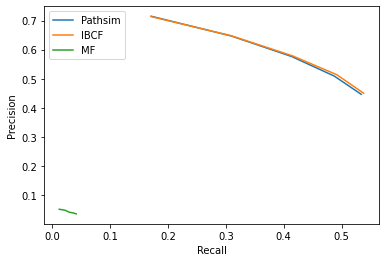

In [16]:
z = zip(precisions,recalls)

for precision,recall in z:
    plt.plot(recall,precision)


# plt.plot(ub_recalls,ub_precisions, ib_recalls,ib_precisions,pop_recalls,pop_precisions)


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(methods)
plt.show()

In [17]:
counter = 0
for method in methods:
    print(f'Method : {method}\n Precision: {np.round(precisions[counter],4)} \n Recall :   {np.round(recalls[counter],4)} \n Explainability :    {np.round(explainabilities[counter],4)}')
    counter+=1

Method : Pathsim
 Precision: [0.7149 0.647  0.5765 0.5091 0.4464] 
 Recall :   [0.171  0.3094 0.4135 0.4873 0.5338] 
 Explainability :    [0.2818 0.7685 1.3963 2.1396 3.0095]
Method : IBCF
 Precision: [0.7137 0.6476 0.5787 0.5138 0.4501] 
 Recall :   [0.1707 0.3097 0.4151 0.4917 0.5381] 
 Explainability :    [0.2809 0.7658 1.39   2.1299 2.9976]
Method : MF
 Precision: [0.0511 0.0473 0.041  0.0384 0.035 ] 
 Recall :   [0.0122 0.0226 0.0293 0.0364 0.0415] 
 Explainability :    [0.0211 0.0608 0.1193 0.1929 0.2837]


In [18]:
ddi_metric

[[1, 858, 2130, 3738, 6140],
 [1, 870, 2148, 3751, 6186],
 [1, 605, 1995, 4062, 6756]]

In [19]:
chart_ddi = []
random_metric = ddi_metric[-1]
for method_ddi in range(0,len(ddi_metric)-1):
    ddi = ddi_metric[method_ddi]
    method_metric = []
    
    for counter in range(0,len(ddi)):
        
        method_metric.append((ddi[counter]-random_metric[counter])/random_metric[counter]*100)
    chart_ddi.append(method_metric)

ddi_metric

#chart_ddi.append(random_metric)

[[1, 858, 2130, 3738, 6140],
 [1, 870, 2148, 3751, 6186],
 [1, 605, 1995, 4062, 6756]]

In [20]:
chart_ddi

[[0.0,
  41.81818181818181,
  6.7669172932330826,
  -7.976366322008863,
  -9.11782119597395],
 [0.0,
  43.80165289256198,
  7.669172932330827,
  -7.656326932545545,
  -8.436944937833037]]

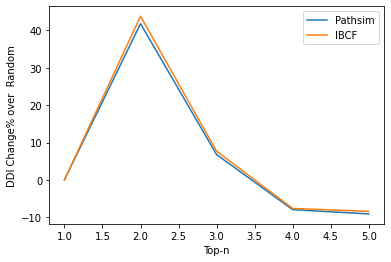

In [21]:
# if 'IBCF_ddi' in methods:
for i in range(0,len(chart_ddi)):
    plt.plot(list(np.arange(1,top_n+1)),chart_ddi[i])
plt.xlabel("Top-n")
plt.ylabel("DDI Change% over  Random")
plt.legend(methods[:-1])
plt.show()

In [22]:
users_for_recommendations = np.asarray(train_set).shape[0]
adv_ddi = []
for metric in ddi_metric:
    worst_ddi = []
    counter = 2
    for top_rec in metric[1:]:
        all_possible_adv = users_for_recommendations*(counter*(counter-1))/2
        worst_ddi.append(top_rec/all_possible_adv)
        counter+=1
    adv_ddi.append(worst_ddi)
adv_ddi

[[0.5044091710758377,
  0.4174015285126396,
  0.3662551440329218,
  0.3609641387419165],
 [0.5114638447971781,
  0.4209288653733098,
  0.3675289045659416,
  0.363668430335097],
 [0.3556731334509112,
  0.39094650205761317,
  0.39800117577895355,
  0.39717813051146383]]

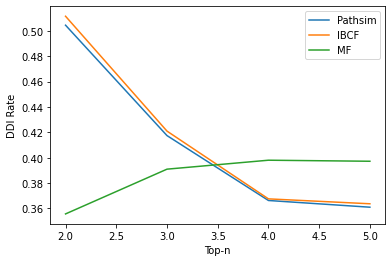

In [23]:
for i in range(0,len(adv_ddi)):
    plt.plot(list(np.arange(2,top_n+1)),adv_ddi[i])
plt.xlabel("Top-n")
plt.ylabel("DDI Rate")
plt.legend(methods)
plt.show()

In [24]:
counter = 0
for method in methods:
    print(f'Method : {method} has {adv_ddi[counter]} DDI Rate')
    counter+=1

Method : Pathsim has [0.5044091710758377, 0.4174015285126396, 0.3662551440329218, 0.3609641387419165] DDI Rate
Method : IBCF has [0.5114638447971781, 0.4209288653733098, 0.3675289045659416, 0.363668430335097] DDI Rate
Method : MF has [0.3556731334509112, 0.39094650205761317, 0.39800117577895355, 0.39717813051146383] DDI Rate
